In [127]:
### IMPORTS ###
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import warnings
from IPython.display import display, Markdown

In [128]:
### PANDAS SETTINGS ###
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
### SETTINGS AND DATA LOADING ###
settings = [
    0, # 0: no scaling 1: Apply scaling
    0  # 0: MinMaxScaler, 1: StandardScaler
]   
df = pd.read_csv('dataset_malwares.csv')
warnings.filterwarnings("ignore")

In [130]:
### DATA PREPROCESSING ###
high_var_columns = [
    'e_lfanew', 'NumberOfSections', 'TimeDateStamp', 'SizeOfOptionalHeader',
    'Characteristics', 'Magic', 'MajorLinkerVersion', 'MinorLinkerVersion', 'SizeOfCode',
    'SizeOfInitializedData', 'SizeOfUninitializedData', 'AddressOfEntryPoint', 'BaseOfCode',
    'ImageBase', 'SectionAlignment', 'FileAlignment', 'MajorOperatingSystemVersion',
    'MinorOperatingSystemVersion', 'MajorImageVersion', 'MinorImageVersion',
    'MajorSubsystemVersion', 'MinorSubsystemVersion', 'SizeOfHeaders', 'SizeOfImage',
    'Subsystem', 'DllCharacteristics', 'SizeOfStackReserve', 'SizeOfStackCommit', 'Malware',
    'SuspiciousImportFunctions', 'SectionsLength', 'SectionMinEntropy', 'SectionMinRawsize',
    'SectionMinVirtualsize', 'SectionMaxPhysical', 'SectionMaxVirtual', 'SectionMaxPointerData',
    'SectionMaxChar', 'DirectoryEntryImport', 'DirectoryEntryImportSize', 'DirectoryEntryExport',
    'ImageDirectoryEntryImport', 'ImageDirectoryEntryResource', 'ImageDirectoryEntrySecurity'
]

df_reduced = df.drop(columns=['Name', 'Machine', 'e_magic',
    'SectionMaxEntropy', 'SectionMaxRawsize', 'SectionMaxVirtualsize',
    'SectionMinPhysical', 'SectionMinVirtual', 'SectionMinPointerData', 'SectionMainChar'])

correlation_matrix = df_reduced.corr()
strong_correlations = correlation_matrix[correlation_matrix.abs() > 0.5]
strong_correlations = strong_correlations[strong_correlations.abs() < 0.95]
strong_pairs = strong_correlations.unstack().dropna().sort_values(ascending=False)
strong_pairs = strong_pairs[strong_pairs < 1]

strong_pairs_columns = set()
for pair in strong_pairs.index:
    strong_pairs_columns.add(pair[0])
    strong_pairs_columns.add(pair[1])

df_reduced_strong = df[list(strong_pairs_columns)]

In [131]:
### SHOW STRONG CORRELATIONS ###
strong_pairs_df = strong_pairs.reset_index()
strong_pairs_df.columns = ['Feature 1', 'Feature 2', 'Correlation']

display(Markdown("### Strongly correlated feature pairs"))
display(strong_pairs_df)

### Strongly correlated feature pairs

,Feature 1,Feature 2,Correlation
0,MajorOperatingSystemVersion,MinorOperatingSystemVersion,0.903229
1,MinorOperatingSystemVersion,MajorOperatingSystemVersion,0.903229
2,SizeOfOptionalHeader,Magic,0.901430
3,Magic,SizeOfOptionalHeader,0.901430
4,BaseOfCode,MinorOperatingSystemVersion,0.886411
5,MinorOperatingSystemVersion,BaseOfCode,0.886411
6,AddressOfEntryPoint,SectionMaxPointerData,0.882988
7,SectionMaxPointerData,AddressOfEntryPoint,0.882988
8,e_cparhdr,e_minalloc,0.866721
9,e_minalloc,e_cparhdr,0.866721


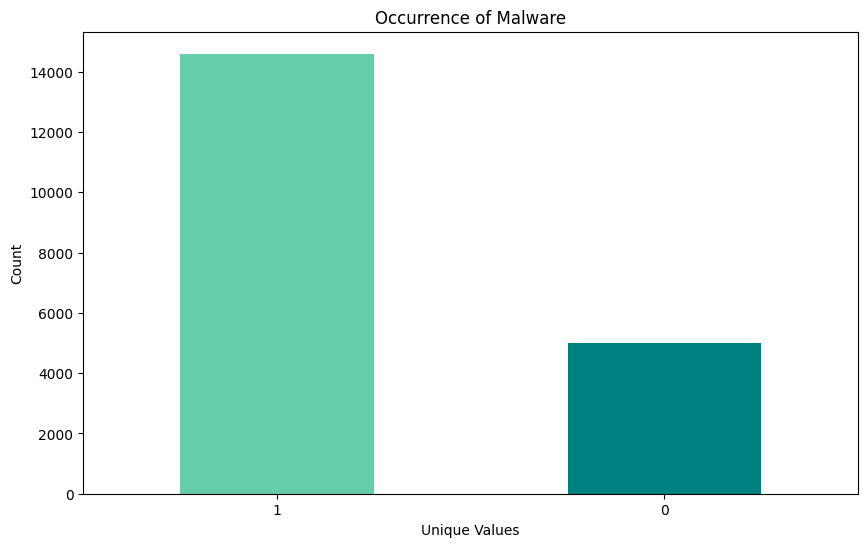

In [132]:
### DATA VISUALIZATION ###
df_reduced_strong['Malware'].value_counts().plot(kind='bar', figsize=(10, 6), color=['mediumaquamarine', 'teal'])
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.title('Occurrence of Malware')
plt.xticks(rotation=0)
plt.show()

In [133]:
### DATA SPLITTING ###
Y = df_reduced_strong['Malware']
X = df_reduced_strong.drop(columns=['Malware'])

df_reduced_strong, df_validation, df_reduced_strong_y, df_validation_y = train_test_split(X, Y, test_size=0.1, shuffle=True)
df_reduced_strong['Malware'] = df_reduced_strong_y

In [134]:
### SCALING ###
if settings[0] == 1:
    if settings[1] == 0:
        scaler = MinMaxScaler()
    elif settings[1] == 1:
        scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df_reduced_strong)

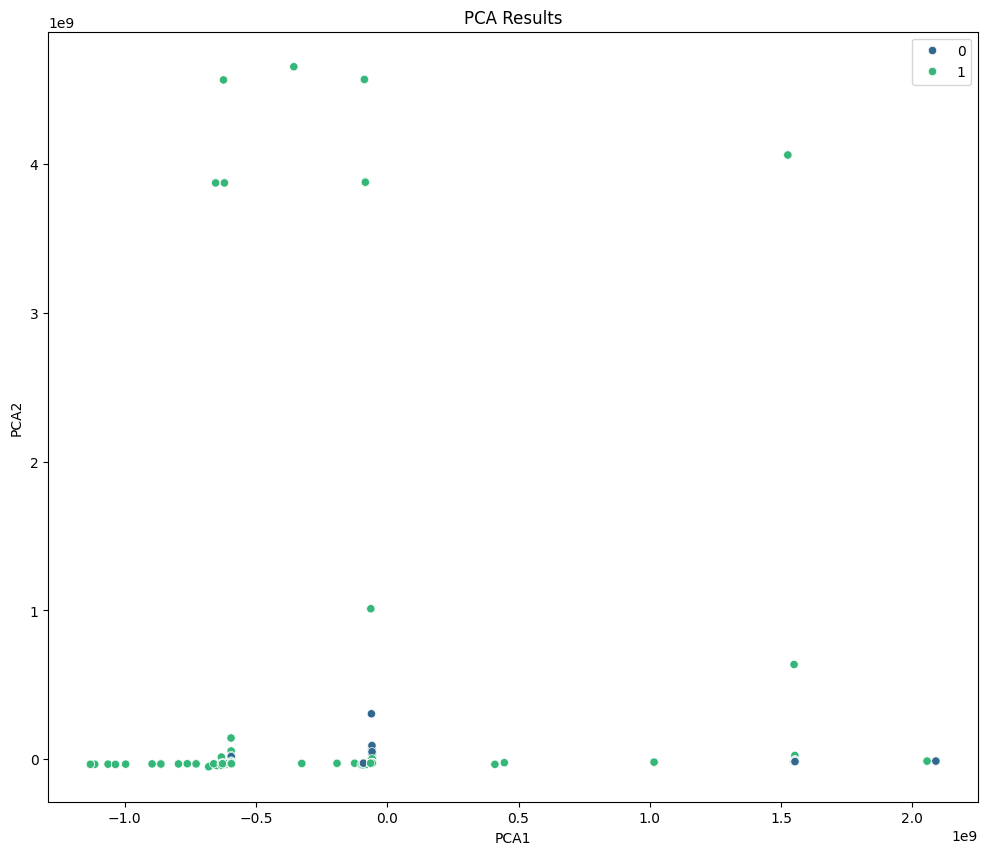

In [135]:
### PCA ###
pca = PCA(n_components=2)
if settings[0] == 1:
    df_pca = pca.fit_transform(df_scaled)
else:
    df_pca = pca.fit_transform(df_reduced_strong)

df_reduced_strong['PCA1'] = df_pca[:, 0]
df_reduced_strong['PCA2'] = df_pca[:, 1]

plt.figure(figsize=(12, 10))
sns.scatterplot(x='PCA1', y='PCA2', hue='Malware', data=df_reduced_strong, palette='viridis')
plt.title('PCA Results')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

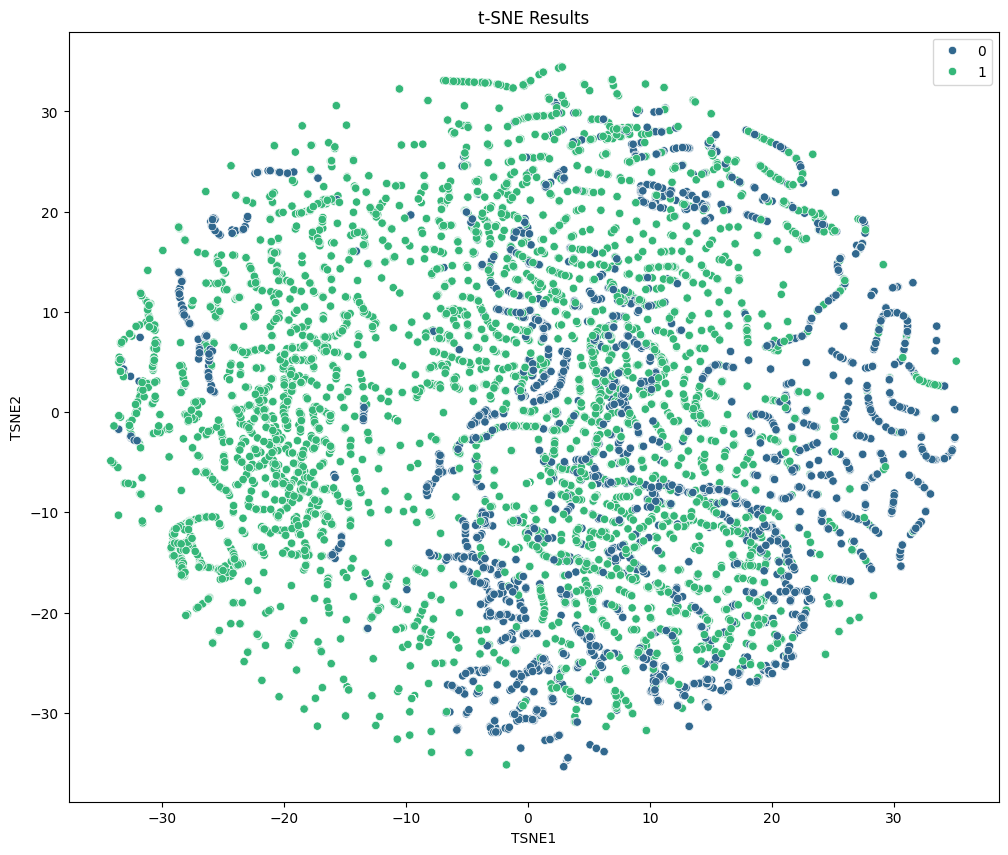

In [136]:
### t-SNE ###
perplexities = [5]
learning_rates = [10]
best_score = -1
best_params = None

for perplexity in perplexities:
    for lr in learning_rates:
        tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=lr, random_state=42, init='pca', n_iter=1000)
        if settings[0] == 1:
            tsne_results = tsne.fit_transform(df_scaled)
        else:
            tsne_results = tsne.fit_transform(df_reduced_strong)

        silhouette_avg = silhouette_score(df_reduced_strong, tsne_results[:, 0])
        if silhouette_avg > best_score:
            best_score = silhouette_avg
            df_tsne = tsne_results
            df_reduced_strong['TSNE1'] = df_tsne[:, 0]
            df_reduced_strong['TSNE2'] = df_tsne[:, 1]

plt.figure(figsize=(12, 10))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='Malware', data=df_reduced_strong, palette='viridis')
plt.title('t-SNE Results')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend()
plt.show()

## Feature Set 1: No Reduction

,Accuracy,Precision,Recall
0,0.924363,0.948660,0.950454
1,0.916431,0.946469,0.941821
2,0.911898,0.948501,0.933081
3,0.913598,0.945524,0.938729
4,0.905382,0.939324,0.932876
5,0.907082,0.939855,0.935582
6,0.920963,0.949676,0.944276
7,0.909915,0.939127,0.939127
8,0.918980,0.943155,0.946082
9,0.916147,0.949319,0.939371


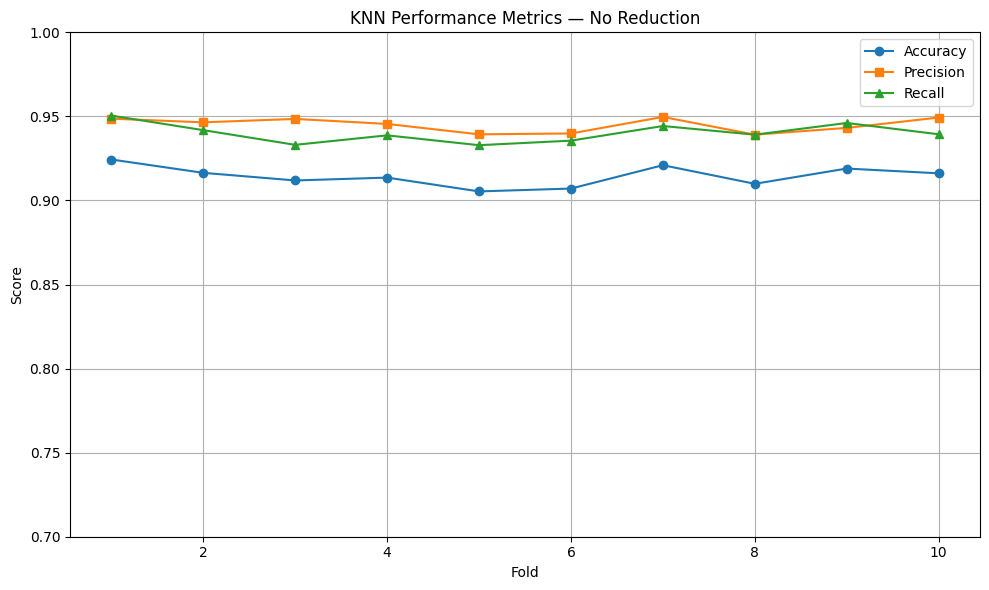

Confusion Matrix for KNN Fold 1:

,Predicted Yes,Predicted No
Actual Yes,750,136
Actual No,131,2513


Confusion Matrix for KNN Fold 2:

,Predicted Yes,Predicted No
Actual Yes,742,141
Actual No,154,2493


Confusion Matrix for KNN Fold 3:

,Predicted Yes,Predicted No
Actual Yes,751,134
Actual No,177,2468


Confusion Matrix for KNN Fold 4:

,Predicted Yes,Predicted No
Actual Yes,743,143
Actual No,162,2482


Confusion Matrix for KNN Fold 5:

,Predicted Yes,Predicted No
Actual Yes,750,158
Actual No,176,2446


Confusion Matrix for KNN Fold 6:

,Predicted Yes,Predicted No
Actual Yes,733,158
Actual No,170,2469


Confusion Matrix for KNN Fold 7:

,Predicted Yes,Predicted No
Actual Yes,760,132
Actual No,147,2491


Confusion Matrix for KNN Fold 8:

,Predicted Yes,Predicted No
Actual Yes,759,159
Actual No,159,2453


Confusion Matrix for KNN Fold 9:

,Predicted Yes,Predicted No
Actual Yes,805,147
Actual No,139,2439


Confusion Matrix for KNN Fold 10:

,Predicted Yes,Predicted No
Actual Yes,724,134
Actual No,162,2510


### Mean Accuracy for KNN n=10: 0.9144759206798867

## Feature Set 2: PCA

,Accuracy,Precision,Recall
0,0.811331,0.859265,0.889658
1,0.810198,0.859501,0.890875
2,0.813031,0.860866,0.892993
3,0.816997,0.877903,0.879880
4,0.818414,0.867231,0.893859
5,0.822380,0.863536,0.902261
6,0.807365,0.856341,0.885493
7,0.817564,0.866445,0.892190
8,0.812181,0.866815,0.885488
9,0.803116,0.853730,0.886641


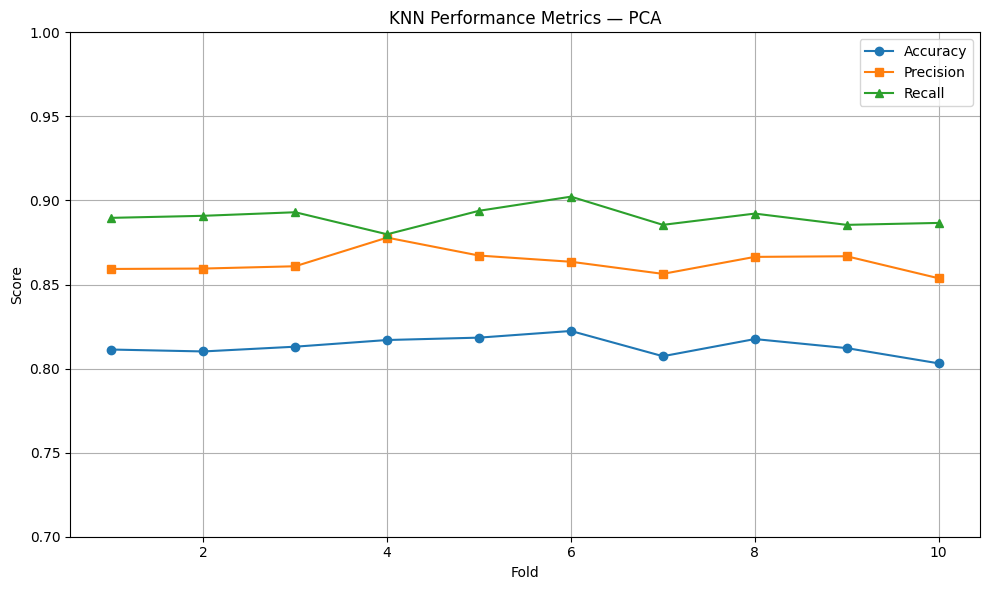

Confusion Matrix for KNN Fold 1:

,Predicted Yes,Predicted No
Actual Yes,550,379
Actual No,287,2314


Confusion Matrix for KNN Fold 2:

,Predicted Yes,Predicted No
Actual Yes,517,383
Actual No,287,2343


Confusion Matrix for KNN Fold 3:

,Predicted Yes,Predicted No
Actual Yes,525,379
Actual No,281,2345


Confusion Matrix for KNN Fold 4:

,Predicted Yes,Predicted No
Actual Yes,540,326
Actual No,320,2344


Confusion Matrix for KNN Fold 5:

,Predicted Yes,Predicted No
Actual Yes,531,361
Actual No,280,2358


Confusion Matrix for KNN Fold 6:

,Predicted Yes,Predicted No
Actual Yes,549,372
Actual No,255,2354


Confusion Matrix for KNN Fold 7:

,Predicted Yes,Predicted No
Actual Yes,561,384
Actual No,296,2289


Confusion Matrix for KNN Fold 8:

,Predicted Yes,Predicted No
Actual Yes,544,361
Actual No,283,2342


Confusion Matrix for KNN Fold 9:

,Predicted Yes,Predicted No
Actual Yes,524,360
Actual No,303,2343


Confusion Matrix for KNN Fold 10:

,Predicted Yes,Predicted No
Actual Yes,512,398
Actual No,297,2323


### Mean Accuracy for KNN n=10: 0.813257790368272

## Feature Set 3: t-SNE

,Accuracy,Precision,Recall
0,0.895751,0.931233,0.927669
1,0.898300,0.933435,0.929524
2,0.902833,0.934343,0.932532
3,0.914731,0.946585,0.939061
4,0.895751,0.932842,0.924942
5,0.899717,0.931897,0.931897
6,0.896601,0.937719,0.921576
7,0.900283,0.934522,0.929480
8,0.896317,0.932567,0.927591
9,0.901700,0.935398,0.932190


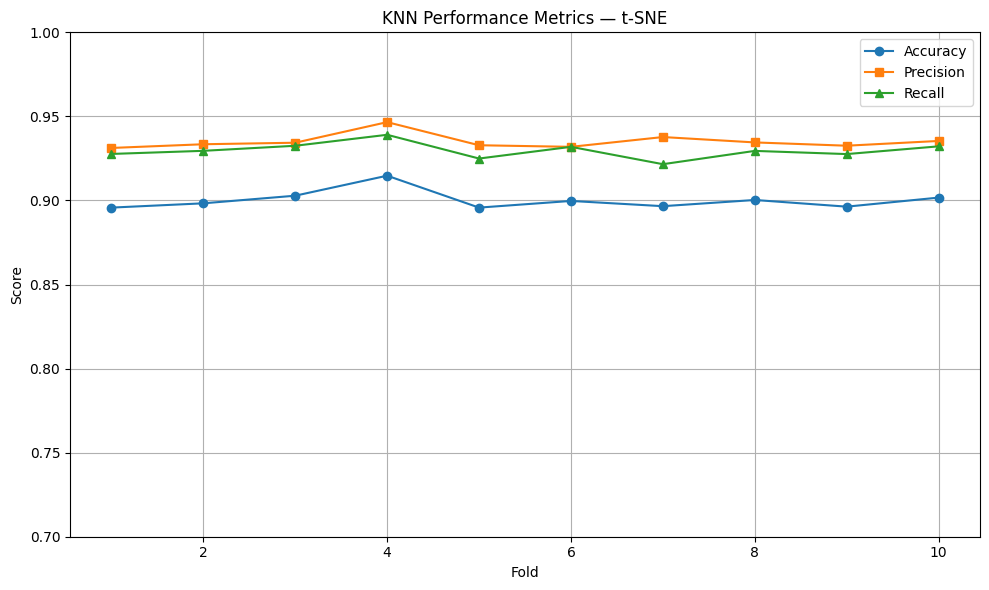

Confusion Matrix for KNN Fold 1:

,Predicted Yes,Predicted No
Actual Yes,738,179
Actual No,189,2424


Confusion Matrix for KNN Fold 2:

,Predicted Yes,Predicted No
Actual Yes,731,174
Actual No,185,2440


Confusion Matrix for KNN Fold 3:

,Predicted Yes,Predicted No
Actual Yes,782,169
Actual No,174,2405


Confusion Matrix for KNN Fold 4:

,Predicted Yes,Predicted No
Actual Yes,748,140
Actual No,161,2481


Confusion Matrix for KNN Fold 5:

,Predicted Yes,Predicted No
Actual Yes,759,173
Actual No,195,2403


Confusion Matrix for KNN Fold 6:

,Predicted Yes,Predicted No
Actual Yes,754,177
Actual No,177,2422


Confusion Matrix for KNN Fold 7:

,Predicted Yes,Predicted No
Actual Yes,756,160
Actual No,205,2409


Confusion Matrix for KNN Fold 8:

,Predicted Yes,Predicted No
Actual Yes,766,169
Actual No,183,2412


Confusion Matrix for KNN Fold 9:

,Predicted Yes,Predicted No
Actual Yes,730,176
Actual No,190,2434


Confusion Matrix for KNN Fold 10:

,Predicted Yes,Predicted No
Actual Yes,736,169
Actual No,178,2447


### Mean Accuracy for KNN n=10: 0.9001983002832862

In [137]:
### K-NEAREST NEIGHBORS ###
neighbors = 10

# Initialize K-Fold cross-validation with 10 folds
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Feature sets and target variable
X_sets = [
    df_reduced_strong.drop(columns=['Malware', 'PCA1', 'PCA2', 'TSNE1', 'TSNE2']),  # No reduction
    df_reduced_strong[['PCA1', 'PCA2']],  # PCA
    df_reduced_strong[['TSNE1', 'TSNE2']]  # t-SNE
]
Y = df_reduced_strong['Malware']

best_model = None
best_accuracy = 0
best_scaler = None
best_reduction = None

# Loop through each feature set
for feature_set_idx, X in enumerate(X_sets):
    feature_set_name = 'No Reduction' if feature_set_idx == 0 else 'PCA' if feature_set_idx == 1 else 't-SNE'
    display(Markdown(f"## Feature Set {feature_set_idx + 1}: {feature_set_name}"))

    accuracies = []
    precisions = []
    recalls = []
    confusion_matrices_KNN = []

    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

        if settings[0] == 1:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

        knn = KNeighborsClassifier(n_neighbors=neighbors)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)

        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)

        if acc > best_accuracy:
            best_accuracy = acc
            best_model = knn
            best_reduction = feature_set_idx
            if settings[0] == 1:
                best_scaler = scaler

        confusion_matrices_KNN.append(pd.DataFrame(
            confusion_matrix(y_test, y_pred),
            index=['Actual Yes', 'Actual No'],
            columns=['Predicted Yes', 'Predicted No']
        ))

    df_metrics = pd.DataFrame({"Accuracy": accuracies, "Precision": precisions, "Recall": recalls})
    display(df_metrics)

    # Plot metrics
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), accuracies, marker='o', label='Accuracy')
    plt.plot(range(1, 11), precisions, marker='s', label='Precision')
    plt.plot(range(1, 11), recalls, marker='^', label='Recall')
    plt.title(f'KNN Performance Metrics — {feature_set_name}')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.ylim(0.7, 1)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    for i, cm in enumerate(confusion_matrices_KNN, start=1):
        display(Markdown(f'Confusion Matrix for KNN Fold {i}:'))
        display(cm)
    mean_accuracy = np.mean(accuracies)
    display(Markdown(f'### Mean Accuracy for KNN n={neighbors}: {mean_accuracy}'))

    if feature_set_idx < 2: print("\n\n")

In [138]:
### VALIDATION ###
y_val = df_validation_y
if settings[0] == 1:
    df_scaled = best_scaler.fit_transform(df_validation)

if best_reduction == 1:
    print("PCA SELECTED")
    pca = PCA(n_components=2)
    if settings[0] == 1:
        df_pca = pca.fit_transform(df_scaled)
    else:
        df_pca = pca.fit_transform(df_validation)
    df_validation['PCA1'] = df_pca[:, 0]
    df_validation['PCA2'] = df_pca[:, 1]
    
    X_val = df_validation[['PCA1', 'PCA2']]
elif best_reduction == 2:
    print("TSNE SELECTED")
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=lr, random_state=42, init="pca", n_iter=1000)
    if settings[0] == 1:
        tsne_results = tsne.fit_transform(df_scaled)
    else:
        tsne_results = tsne.fit_transform(df_validation)
    df_validation['TSNE1'] = tsne_results[:, 0]
    df_validation['TSNE2'] = tsne_results[:, 1]

    X_val = df_validation[['TSNE1', 'TSNE2']]
else:
    print("NO TRANSFORM METHOD SELECTED")
    if settings[0] == 1:
        X_val = best_scaler.transform(df_validation)
    else:
        X_val = df_validation

y_val_pred = best_model.predict(X_val)
acc_val = accuracy_score(y_val, y_val_pred)
prec_val = precision_score(y_val, y_val_pred, zero_division=0)
rec_val = recall_score(y_val, y_val_pred, zero_division=0)

y_modified = np.where(
    (y_val_pred != y_val) & (y_val_pred != y_train.min()), 2,  # False Positive → 2
    np.where((y_val_pred != y_val) & (y_val_pred == y_train.min()), 3, y_val_pred)  # False Negative → 3
)

X_val['Malware'] = y_modified

X_val["Malware"] = X_val["Malware"].replace({
    0: "True Positive",
    1: "True Negative",
    2: "False Positive",
    3: "False Negative"
})

df_reduced_strong["Malware"] = df_reduced_strong["Malware"].replace({
    0: "True Positive",
    1: "True Negative",
    2: "False Positive",
    3: "False Negative"
})

display(Markdown("## VALIDATION"))
df_validation = pd.DataFrame([[acc_val, prec_val, rec_val]], columns=['Accuracy', 'Precision', 'Recall'])
display(df_validation.style.hide(axis="index"))

NO TRANSFORM METHOD SELECTED


## VALIDATION

Accuracy,Precision,Recall
0.909786,0.940725,0.936155


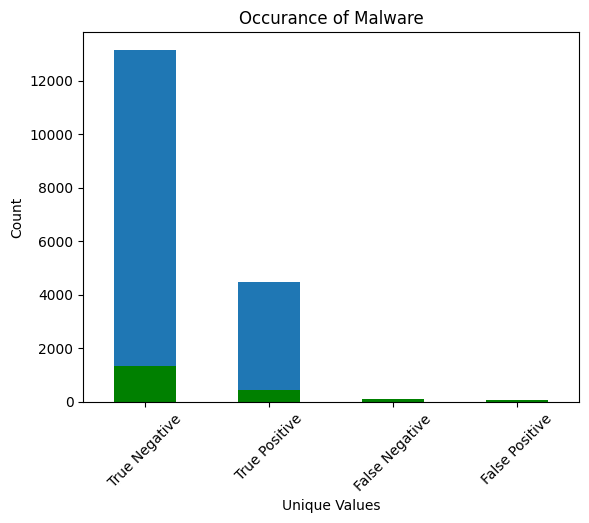

In [139]:
### VISUALIZATION ###
if best_reduction == 1:
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Malware', data=df_reduced_strong, palette='viridis', alpha=0.5)
    sns.scatterplot(x='PCA1', y='PCA2', hue='Malware', data=X_val, palette='viridis')
    plt.title('Original vs predicted validation placement')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()
elif best_reduction == 2:
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='Malware', data=df_reduced_strong, palette='viridis', alpha=0.5)
    sns.scatterplot(x='TSNE1', y='TSNE2', hue='Malware', data=X_val, palette='viridis')
    plt.title('Original vs predicted validation placement')
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.show()
else:
    df_reduced_strong['Malware'].value_counts().plot(kind='bar')
    X_val['Malware'].value_counts().plot(kind='bar', color='green')
    plt.xlabel('Unique Values')
    plt.ylabel('Count')
    plt.title(f'Occurance of Malware')
    plt.xticks(rotation=45)
    plt.show()